## Classification on Unseen Image
To use the saved model to classify unseen images, the mode is loadel and then appiey it to the new image on test datasets for inference.

In [1]:
import torch
from torchvision import models, transforms
from PIL import Image
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import torchvision
import pathlib
import os

In [2]:
# Ensure you define the classes list based on your label map
classes = ['not_car', 'car']

In [3]:
# Load the saved model
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 1000)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('resnet18_checkpoint.model'))
model.eval()

C:\Users\sudur\miniconda3\envs\DeepLearning\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\sudur\miniconda3\envs\DeepLearning\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [5]:
# Create a new model with the correct final layer
new_model = models.resnet18(pretrained=True)
new_model.fc = nn.Linear(new_model.fc.in_features, 2)  # Adjust to match the desired output units

In [6]:
# Copy the weights and biases from the loaded model to the new model
new_model.fc.weight.data = model.fc.weight.data[0:2]  # Copy only the first 2 output units
new_model.fc.bias.data = model.fc.bias.data[0:2]

In [7]:
from torch.utils.data import Dataset
from torchvision.io import read_image, ImageReadMode
class CustomDataset(Dataset):
    def __init__(self, img_dir, labels, transform=None):
        self.img_dir = img_dir
        self.labels = labels
        self.transform = transform
        self.file_paths = []
        self.label_map = {'not_car': 0, 'car': 1}
        self.classes = labels
        
        for lab in self.labels:
            label_folder = os.path.join(str(img_dir), lab)
            file_list = [os.path.join(label_folder, file.name).replace('\\', '/') for file in os.scandir(label_folder) if file.is_file()]
            self.file_paths.extend([(file, lab) for file in file_list])
    
    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        img_path, label = self.file_paths[idx]
        image = read_image(img_path, mode=ImageReadMode.RGB).float() / 255.0 # Scale to [0, 1]
        if self.transform:
            image = self.transform(image)
        label_id = self.label_map[label]
        return image, label_id, img_path
        
# Example usage
train_dir = 'D:/MSRSGI/Summer_Semester24/DL/Exercises/Exercise1/WorkingData/data/train'
test_dir = 'D:/MSRSGI/Summer_Semester24/DL/Exercises/Exercise1/WorkingData/data/test'
labels = ['not_car', 'car']  # Ensure this matches your directory structure

# Define the transforms
import torchvision.transforms as transforms

data_transforms = transforms.Compose([
    transforms.Resize((224, 224))
    # transforms.ToTensor()
])

test_transforms_norm = transforms.Compose([
    transforms.Resize((224, 224)),
    # transforms.ToTensor(),
    transforms.Normalize([0.4670, 0.4365, 0.4319],[0.1659, 0.1498, 0.1380])
])

train_dataset = CustomDataset(train_dir, labels, transform = data_transforms) 
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=32, shuffle=True) #takes an image not a tensor 

test_dataset_norm = CustomDataset(test_dir, labels, transform = test_transforms_norm)

test_dataloader_norm = torch.utils.data.DataLoader(dataset=test_dataset_norm, batch_size=32, shuffle=True) #takes an image not a tensor

In [8]:
len(test_dataset_norm)

1346

In [9]:
len(test_dataloader_norm)

43

Classification Report:
               precision    recall  f1-score   support

     not_car       0.95      0.97      0.96       946
         car       0.91      0.89      0.90       400

    accuracy                           0.94      1346
   macro avg       0.93      0.93      0.93      1346
weighted avg       0.94      0.94      0.94      1346

Confusion Matrix:
 [[913  33]
 [ 46 354]]


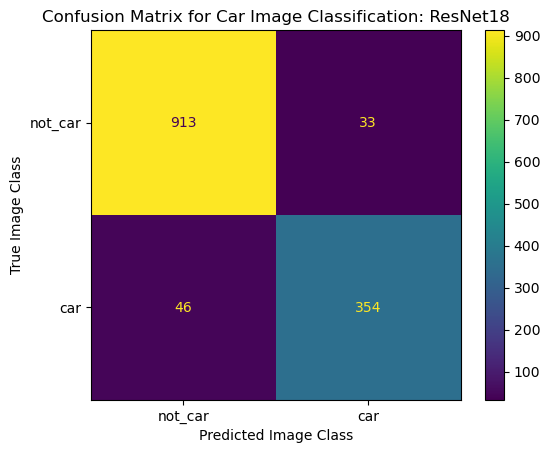

In [16]:
import os
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Function to set the seed for reproducibility
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # for numpy
    random.seed(seed)  # for python random
    torch.backends.cudnn.deterministic = True  # to make results reproducible
    torch.backends.cudnn.benchmark = False  # to avoid non-deterministic algorithms

# Set the seed for reproducibility
set_seed(42)  # Replace 42 with any number you prefer


# # Set the model to evaluation mode
# model.eval()

# List to store results
results = []

# Disable gradient calculations
with torch.no_grad():
    # Initialize variables for predictions and true labels
    predicted_labels = []
    true_labels = [] 
    for images, labels, file_paths in test_dataloader_norm:
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = new_model(images)
        
        # Calculate predicted labels
        _, predicted = torch.max(outputs.data, 1)
        
        # Update predicted labels and true labels
        predicted_labels.extend(predicted.cpu().tolist())
        true_labels.extend(labels.cpu().tolist())
        
        # Store the results for each image in the batch
        for i in range(images.size(0)):
            filename = os.path.basename(file_paths[i])
            true_label = classes[labels[i].item()]
            predicted_label = classes[predicted[i].item()]
            results.append({
                'file_path': file_paths[i].replace('\\', '/'),  # Normalize the path separators
                'true_class': true_label,
                'predicted_class': predicted_label
            })

# Calculate precision, recall, F1-score, and overall accuracy
classification_rep = classification_report(true_labels, predicted_labels, target_names=classes)
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Display the classification report and confusion matrix
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", confusion_mat)

# Create a DataFrame and save to CSV
df = pd.DataFrame(results)
df.to_csv('Predictions/Resnet18_Prediction_Final.csv', index=False)

# Optionally, display the confusion matrix using ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=classes)
disp.plot()
plt.xlabel("Predicted Image Class")
plt.ylabel("True Image Class")
plt.title("Confusion Matrix for Car Image Classification: ResNet18")
plt.savefig('Results/ConfusionMatrixResNet18.pdf')
plt.show()

In [17]:
# From the confusion matrix, we can directly extract the information on the classification results and compute performance metrics of the classifier 
#not-car=0
#car=1
TN = confusion_mat[0][0] # True negative
FN = confusion_mat[1][0] # False negative
TP = confusion_mat[1][1] # True positive
FP = confusion_mat[0][1] # False positive

## We discussed these metrics of the confusion matrix in the lecture
# Probability of detection, also: sensitivity, hit rate, recall, or true positive rate
POD = TP/(TP+FN)
# Overall accuracy, also percent correct (multiply by 100 to convert to %)
ACC = (TP+TN)/(TP+FP+FN+TN)
# False alarm rate
FAR = FP/(TP+FP)
# Bias score
BS = (TP+FP)/(TP+FN)

## some additional metrics
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)

print("Probability of detection: ", round(POD,3))
print("Overall accuracy: ", round(ACC,3))
print("False alarm rate: ", round(FAR,3))
print("Bias score: ", round(BS,3))
print("False positive rate: ", round(FPR,3))

Probability of detection:  0.885
Overall accuracy:  0.941
False alarm rate:  0.085
Bias score:  0.968
False positive rate:  0.035


In [18]:
import sklearn.metrics
import matplotlib.pyplot as plt
# import seaborn as sns
fpr,tpr,thresholds=sklearn.metrics.roc_curve(true_labels, predicted_labels)

print(sklearn.metrics.auc(fpr,tpr))
print(sklearn.metrics.confusion_matrix(true_labels,np.rint(predicted_labels)))

0.9250581395348838
[[913  33]
 [ 46 354]]


In [19]:
sklearn.metrics.accuracy_score(true_labels, predicted_labels) #overall accuracy

0.9413075780089153

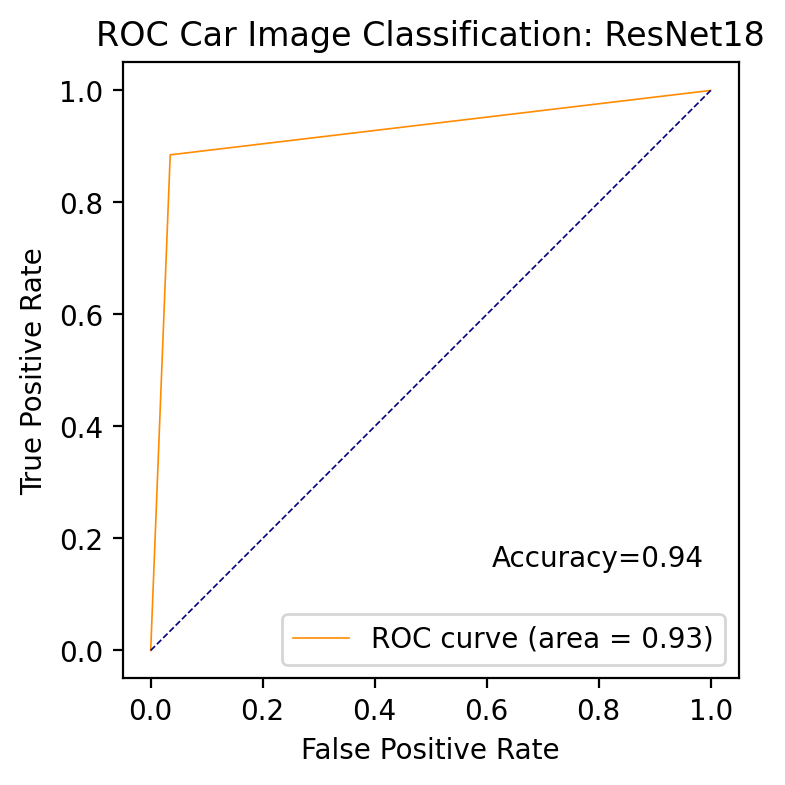

In [20]:
plt.figure(figsize=(4,4),dpi=200)
lw = 0.6
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % 0.93,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Car Image Classification: ResNet18")
plt.text(0.61, 0.15,"Accuracy=0.94")
plt.legend(loc="lower right")
plt.savefig('Results/rocResNet18.pdf')
plt.axis('square')
plt.show()

In [21]:
df

,file_path,true_class,predicted_class
0,D:/MSRSGI/Summer_Semester24/DL/Exercises/Exerc...,not_car,not_car
1,D:/MSRSGI/Summer_Semester24/DL/Exercises/Exerc...,not_car,not_car
2,D:/MSRSGI/Summer_Semester24/DL/Exercises/Exerc...,car,car
3,D:/MSRSGI/Summer_Semester24/DL/Exercises/Exerc...,not_car,not_car
4,D:/MSRSGI/Summer_Semester24/DL/Exercises/Exerc...,not_car,not_car
...,...,...,...
1341,D:/MSRSGI/Summer_Semester24/DL/Exercises/Exerc...,not_car,not_car
1342,D:/MSRSGI/Summer_Semester24/DL/Exercises/Exerc...,car,car
1343,D:/MSRSGI/Summer_Semester24/DL/Exercises/Exerc...,car,car
1344,D:/MSRSGI/Summer_Semester24/DL/Exercises/Exerc...,not_car,not_car


## References:
i. https://scikit-learn.org/stable/index.html

ii. https://github.com/AarohiSingla/Image-Classification-Using-Pytorch/blob/main/image_classification.ipynb

iii. https://github.com/ashokdahal/ExplainableAI/blob/main/TrainAndTestRevison1.ipynb

iv. Andersen, H., Exercise(WS23/24 ), Machine Learning for classification|Data Analysis in Geoscience and Remote Sensing Projects